In [1]:
# ------------------------------------------define logging and working directory
from ProjectRoot import change_wd_to_project_root
change_wd_to_project_root()

from src.utils.Tensorflow_helper import choose_gpu_by_id
# ------------------------------------------define GPU id/s to use
GPU_IDS = '0,1'
GPUS = choose_gpu_by_id(GPU_IDS)
print(GPUS)

# this should import glob, os, and many other standard libs
from src.utils.Notebook_imports import *

# local imports
from src.utils.Utils_io import Console_and_file_logger, init_config
from src.visualization.Visualize import show_2D_or_3D

# import external libs
import cv2
import pandas as pd

# ------------------------------------------jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

EXPERIMENT = 'temp/windowmotion'
timestemp = str(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")) # ad a timestep to each project to make repeated experiments unique

EXPERIMENTS_ROOT = 'exp/'
EXP_PATH = os.path.join(EXPERIMENTS_ROOT, EXPERIMENT, timestemp)
MODEL_PATH = os.path.join(EXP_PATH, 'model', )
TENSORBOARD_PATH = os.path.join(EXP_PATH, 'tensorboard_logs')
CONFIG_PATH = os.path.join(EXP_PATH,'config')
HISTORY_PATH = os.path.join(EXP_PATH, 'history')
ensure_dir(MODEL_PATH)
ensure_dir(TENSORBOARD_PATH)
ensure_dir(CONFIG_PATH)
ensure_dir(HISTORY_PATH)

# define the input data paths and fold 
# first to the 4D Nrrd files, 
# second to a dataframe with a mapping of the Fold-number
# Finally the path to the metadata
DATA_PATH_SAX = '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/'
DF_FOLDS = '/mnt/ssd/data/gcn/metadata/df_kfold.csv'
DF_META = '/mnt/ssd/data/gcn/metadata/SAx_3D_dicomTags_phase'
FOLD = 0

# ------------------------------------------generator hyperparameters
SEED = 42 # define a seed for the generator shuffle
BATCHSIZE = 1 # 32, 64, 24, 16, 1 for 3D use: 4
GENERATOR_WORKER = BATCHSIZE # if not set, use batchsize
DIM = [64, 128, 128] # network input params for spacing of 3, (z,y,x)
SPACING = [2, 2, 2] # if resample, resample to this spacing, (z,y,x)
T_SPACING = 55
DEPTH = 3 # depth of the encoder
FILTERS = 16 # initial number of filters, will be doubled after each downsampling block
M_POOL = [2, 2, 2]# size of max-pooling used for downsampling and upsampling
F_SIZE = [3, 3, 3] # conv filter size
# maybe we can drop this channel?
#IMG_CHANNELS = 1 # Currently our model needs that image channel
MASK_VALUES = [1, 2, 3]  #channel order: Background, RV, MYO, LV
MASK_CLASSES = len(MASK_VALUES) # no of labels
MASKING_IMAGE = False
MASKING_VALUES = [1,2,3]
BORDER_MODE = cv2.BORDER_REFLECT_101 # border mode for the data generation
IMG_INTERPOLATION = cv2.INTER_LINEAR # image interpolation in the genarator
MSK_INTERPOLATION = cv2.INTER_NEAREST # mask interpolation in the generator
AUGMENT = True # a compose of 2D augmentation (grid distortion, 90degree rotation, brightness and shift)
AUGMENT_PROB = 0.8
RANDOMROTATE=False
SHIFTSCALEROTATE=False
GRIDDISTORTION=True
DOWNSCALE=False
SHUFFLE = True
RESAMPLE = True
AUGMENT_TEMP = False
AUGMENT_TEMP_RANGE = (-2,2)
RESAMPLE_T = True
HIST_MATCHING = True
SCALER = 'standard' # MinMax Standard or Robust

Console_and_file_logger(EXPERIMENT, logging.INFO)
config = init_config(config=locals(), save=True)
print(config)

search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
['/gpu:0', '/gpu:1']


2021-06-02 10:13:54,059 INFO -------------------- Start --------------------
2021-06-02 10:13:54,060 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-06-02 10:13:54,060 INFO Log file: ./logs/temp/windowmotion.log
2021-06-02 10:13:54,060 INFO Log level for console: INFO


{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/windowmotion', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/temp/windowmotion/2021-06-02_10_13', 'MODEL_PATH': 'exp/temp/windowmotion/2021-06-02_10_13/model', 'TENSORBOARD_PATH': 'exp/temp/windowmotion/2021-06-02_10_13/tensorboard_logs', 'CONFIG_PATH': 'exp/temp/windowmotion/2021-06-02_10_13/config', 'HISTORY_PATH': 'exp/temp/windowmotion/2021-06-02_10_13/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/', 'DF_FOLDS': '/mnt/ssd/data/gcn/metadata/df_kfold.csv', 'DF_META': '/mnt/ssd/data/gcn/metadata/SAx_3D_dicomTags_phase', 'FOLD': 0, 'BATCHSIZE': 1, 'GENERATOR_WORKER': 1, 'DIM': [64, 128, 128], 'SPACING': [2, 2, 2], 'T_SPACING': 55, 'DEPTH': 3, 'FILTERS': 16, 'M_POOL': [2, 2, 2], 'F_SIZE': [3, 3, 3], 'MASK_VALUES': [1, 2, 3], 'MASK_CLASSES': 3, 'MASKING_IMAGE': False, 'MASKING_VALUES': [1, 2, 3], 'BORDER_MODE': 4, 'IMG_INTERPOLATION': 1, 'MSK_INTERPOLATION': 0, 'AUGMENT': True, '

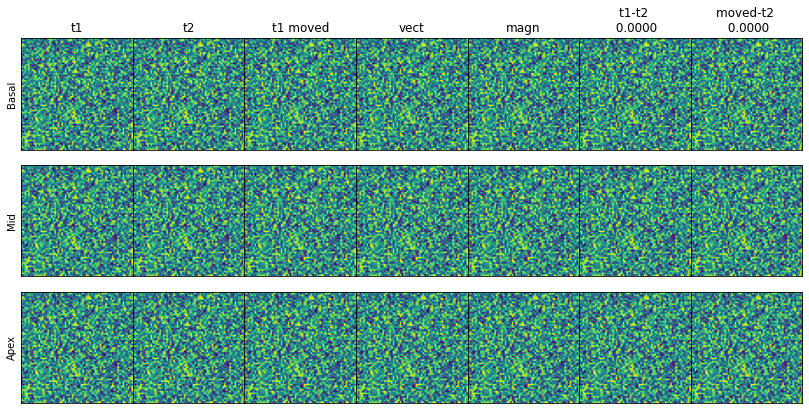

In [12]:
import matplotlib.pyplot as plt
import numpy as np
img = np.random.random((64,64))
nrows = 3
ncols = 7
y_label = ['Basal', 'Mid', 'Apex']
col_titles = ['t1', 't2', 't1 moved', 'vect', 'magn', 't1-t2 \n {:6.4f}'.format(0) ,'moved-t2 \n {:6.4f}'.format(0)]

fig, axes = plt.subplots(nrows, ncols, figsize=(14,7))
ax_flat = axes.flatten()
for ax in ax_flat:
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
# set column names
for i in range(ncols):
    axes[0,i].set_title(col_titles[i])
# set row names
for j in range(nrows):

    axes[j,0].set_ylabel(y_label[j], rotation=90, size='medium')

fig.subplots_adjust(wspace=0.0, hspace=0.0)
#fig.tight_layout()
plt.show()

In [ ]:
# use the trainings script to run fast experiments
from src.models.train_motion_model import main
class Cfg_wrapper:
    cfg = '/mnt/sds/sd20i001/sven/cfgs/phasemotion/v2_32_64_64_baseline.json'
    data = None
temp = Cfg_wrapper()
print(temp.cfg)
main(temp)

2021-06-02 10:20:03,954 INFO -------------------- Start --------------------
2021-06-02 10:20:03,954 INFO Working directory: /mnt/ssd/git/dynamic-cmr-models.
2021-06-02 10:20:03,955 INFO Log file: exp/temp/windowmotion/v2/32_64_64/window2/reg0_001_baseline/_f0/2021-06-02_10_20/Log.log
2021-06-02 10:20:03,955 INFO Log level for console: INFO
2021-06-02 10:20:03,957 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-06-02 10:20:03,957 INFO searched in: /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-06-02 10:20:03,966 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-06-02 10:20:03,966 INFO Patients train: 209
2021-06-02 10:20:03,977 INFO Selected 209 of 278 files with 209 of 279 patients for training fold 0
2021-06-02 10:20:03,977 INFO SAX train CMR: 209, SAX train masks: 209
2021-06-02 10:20:03,978 INFO SAX val CMR: 69, SAX val masks: 69
2021-06-02 10:20:03,992 INFO Check if we find the patient ID and phase mapping for all: 

/mnt/sds/sd20i001/sven/cfgs/phasemotion/v2_32_64_64_baseline.json
search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/dynamic-cmr-models
config given: /mnt/sds/sd20i001/sven/cfgs/phasemotion/v2_32_64_64_baseline.json
{'GPU_IDS': '0,1', 'GPUS': ['/gpu:0', '/gpu:1'], 'SEED': 42, 'EXPERIMENT': 'temp/windowmotion/v2/32_64_64/window2/reg0_001_baseline/', 'EXPERIMENTS_ROOT': 'exp/', 'EXP_PATH': 'exp/temp/windowmotion/v2/32_64_64/window2/reg0_001_baseline/2021-06-02_10_20', 'MODEL_PATH': 'exp/temp/windowmotion/v2/32_64_64/window2/reg0_001_baseline/2021-06-02_10_20/model', 'TENSORBOARD_PATH': 'exp/temp/windowmotion/v2/32_64_64/window2/reg0_001_baseline/2021-06-02_10_20/tensorboard_logs', 'CONFIG_PATH': 'exp/temp/windowmotion/v2/32_64_64/window2/reg0_001_baseline/2021-06-02_10_20/config', 'HISTORY_PATH': 'exp/temp/windowmotion/v2/32_64_64/window2/reg0_001_baseline/2021-06-02_10_20/history', 'DATA_PATH_SAX': '/mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/', 'DF

2021-06-02 10:20:04,263 INFO Done!
2021-06-02 10:20:04,263 INFO Create DataGenerator
2021-06-02 10:20:04,264 INFO Datagenerator created with: 
 shape: [32, 64, 64]
 spacing: [4, 4, 4]
 batchsize: 2
 Scaler: standard
 Images: 209 
 Augment: False 
 Thread workers: 2
2021-06-02 10:20:04,265 INFO No augmentation
2021-06-02 10:20:04,278 INFO params of generator:
2021-06-02 10:20:04,278 INFO [('MASKING_IMAGE', False), ('SINGLE_OUTPUT', False), ('MASKING_VALUES', [1, 2, 3]), ('DEBUG_MODE', False), ('SCALER', 'standard'), ('AUGMENT', False), ('SHUFFLE', True), ('RESAMPLE', True), ('SPACING', [4, 4, 4]), ('SEED', 42), ('DIM', [32, 64, 64]), ('BATCHSIZE', 2), ('MASK_VALUES', [1, 2, 3]), ('N_CLASSES', 3), ('MAX_WORKERS', 2), ('T_SPACING', 34), ('PHASES', 5), ('HIST_MATCHING', False), ('IMG_INTERPOLATION', 1), ('MSK_INTERPOLATION', 0), ('AUGMENT_TEMP', False), ('RESAMPLE_T', True), ('WINDOW_SIZE', 2), ('IMG_CHANNELS', 3), ('ISACDC', False), ('METADATA_FILE', '/mnt/ssd/data/gcn/metadata/SAx_3D_dic

(None, 32, 64, 64, 3)
(None, 32, 64, 64, 3)


2021-06-02 10:20:09,055 INFO feed 4 Tensorboard is ready


start training
Epoch 1/250


In [2]:
# Load SAX volumes
from src.data.Dataset import get_trainings_files
x_train_sax, y_train_sax, x_val_sax, y_val_sax =  get_trainings_files(data_path=DATA_PATH_SAX,path_to_folds_df=DF_FOLDS, fold=FOLD)
logging.info('SAX train CMR: {}, SAX train masks: {}'.format(len(x_train_sax), len(y_train_sax)))
logging.info('SAX val CMR: {}, SAX val masks: {}'.format(len(x_val_sax), len(y_val_sax)))

2021-05-27 11:57:21,692 INFO no files found, try to load with clean.nrrd/mask.nrrd pattern
2021-05-27 11:57:21,693 INFO searched in: /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-05-27 11:57:21,701 INFO Found 278 images/masks in /mnt/ssd/data/gcn/02_imported_4D_unfiltered/sax/
2021-05-27 11:57:21,701 INFO Patients train: 209
2021-05-27 11:57:21,712 INFO Selected 209 of 278 files with 209 of 279 patients for training fold 0
2021-05-27 11:57:21,712 INFO SAX train CMR: 209, SAX train masks: 209
2021-05-27 11:57:21,713 INFO SAX val CMR: 69, SAX val masks: 69


In [3]:
# initialise a generator with these files
# logging.getLogger().setLevel(logging.INFO)
from src.data.Generators import PhaseWindowGenerator
config['AUGMENT'] = True
config['RESAMPLE'] = True
batch_generator = PhaseWindowGenerator(x_train_sax, x_train_sax, config=config)
val_config = config.copy()
val_config['AUGMENT'] = False
val_config['AUGMENT_TEMP'] = False
val_config['HIST_MATCHING'] = False
validation_generator = PhaseWindowGenerator(x_val_sax, x_val_sax , config=val_config)

2021-05-27 11:57:22,320 INFO Create DataGenerator
2021-05-27 11:57:22,322 INFO Datagenerator created with: 
 shape: [64, 128, 128]
 spacing: [2, 2, 2]
 batchsize: 1
 Scaler: standard
 Images: 209 
 Augment: True 
 Thread workers: 1
2021-05-27 11:57:22,322 INFO Data will be augmented (shift,scale and rotate) with albumentation
2021-05-27 11:57:22,335 INFO params of generator:
2021-05-27 11:57:22,336 INFO [('MASKING_IMAGE', False), ('SINGLE_OUTPUT', False), ('MASKING_VALUES', [1, 2, 3]), ('DEBUG_MODE', False), ('SCALER', 'standard'), ('AUGMENT', True), ('SHUFFLE', True), ('RESAMPLE', True), ('SPACING', [2, 2, 2]), ('SEED', 42), ('DIM', [64, 128, 128]), ('BATCHSIZE', 1), ('MASK_VALUES', [1, 2, 3]), ('N_CLASSES', 3), ('MAX_WORKERS', 1), ('T_SPACING', 55), ('PHASES', 5), ('HIST_MATCHING', True), ('IMG_INTERPOLATION', 1), ('MSK_INTERPOLATION', 0), ('AUGMENT_TEMP', False), ('RESAMPLE_T', True), ('WINDOW_SIZE', 2), ('ISACDC', False), ('METADATA_FILE', '/mnt/ssd/data/gcn/metadata/SAx_3D_dicomTa

In [4]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(batch_generator), 1), im = (0,BATCHSIZE- 1, 1), slice_n=(1,11), save=False, filepath='data/temp/', filename='temp_x.npy'):
    
    import time
    global inputs, outputs
    t1 = time.time()
    inputs, outputs = batch_generator.__getitem__(batch)
    if type(inputs)==list:inputs, outputs = inputs[0], outputs[0]
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    
    selected_input = inputs[im]
    selected_output = outputs[im]
    
    list(map(lambda x: show_2D_or_3D(img=x[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_input))
    plt.show()
    info('-'*100)
    list(map(lambda y: show_2D_or_3D(img=y[::slice_n], interpol='bilinear',dpi=100,f_size=(5,5)), selected_output))
    plt.show()

    plt.hist(selected_input.flatten(), bins=np.linspace(0.1,1,20))
    plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
    



interactive(children=(IntSlider(value=104, description='batch', max=209), IntSlider(value=0, description='im',…

In [4]:
# visualise one batch
@interact_manual
def select_image_in_batch(batch = (0,len(batch_generator), 1), im = (0,BATCHSIZE- 1, 1), slice_n=(1,11), save=False, filepath='data/temp/', filename='temp_x.npy'):
    
    import time
    global inputs, outputs
    slice_n =10
    t1 = time.time()
    inputs, outputs = batch_generator.__getitem__(batch)
    if type(inputs)==list:inputs, outputs = inputs[0], outputs[0]
    logging.info('Preprocessing took: {:0.3f}'.format(time.time() - t1))
    print(inputs.shape, outputs.shape)
    print('selected batch : ' + str(batch))
    
    selected_input = inputs[im]
    selected_output = outputs[im]
    
    # plot the pre (t-1) and post (t+1) volume of each cardiac phase and the difference
    #_ = list(map(lambda x : show_two_timesteps(x),  zip(['ED#'],np.stack([selected_input, selected_output], axis=1))))
    _ = list(map(lambda x : show_two_timesteps(x),  zip(['ED#', 'MS#', 'ES#', 'PF#', 'MD#'],np.stack([selected_input, selected_output], axis=1))))
    
    bins = np.linspace(-2,2,20) # modify this for minmax-normalisation
    plt.hist(selected_input.flatten(), bins=bins)
    plt.show()
    if save:
        ensure_dir(filepath)
        np.save(os.path.join(filepath, filename), x[im])
        logging.info('saved to {}'.format(os.path.join(filepath, filename)))
        
def show_two_timesteps(x):
    # x is a tuple of phase (string), ndarray with the following shape: 2,z,x,y --> first and second timestep of the motion window
    p, x = x
    inter, dpi, f_size = 'bilinear', 100, (5,5)
    logging.info('Phase: {}'.format(p))
    f1 = show_2D_or_3D(img=x[0], interpol=inter,dpi=dpi,f_size=f_size);plt.show()
    show_2D_or_3D(img=x[1], interpol=inter,dpi=dpi,f_size=f_size);plt.show()
    show_2D_or_3D(img=x[0] - x[1], interpol=None,dpi=dpi,f_size=f_size);plt.show()
    logging.info("-"*20)
    


interactive(children=(IntSlider(value=104, description='batch', max=209), IntSlider(value=0, description='im',…

In [6]:
from src.models.Models import create_RegistrationModel

import tensorflow

if tensorflow.distribute.has_strategy():
    strategy = tensorflow.distribute.get_strategy()
else:
    # distribute the training with the "mirrored data"-paradigm across multiple gpus if available, if not use gpu 0
    strategy = tensorflow.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
with strategy.scope():
    model = create_RegistrationModel(config=config)

using tensorflow, need to monkey patch
tf.python.backend.slice overwritten by monkey patch
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2021-05-26 16:12:43,974 INFO Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


(None, 64, 128, 128, 1)
(None, 64, 128, 128, 1)
Instructions for updating:
Use fn_output_signature instead


2021-05-26 16:12:45,119 WARNING From /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/util/deprecation.py:574: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Use fn_output_signature instead


In [7]:
model.summary()

Model: "simpleregister"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 5, 64, 128,  0                                            
__________________________________________________________________________________________________
tf_op_layer_unstack (TensorFlow [(None, 64, 128, 128 0           input_1[0][0]                    
__________________________________________________________________________________________________
unet (Functional)               (None, 64, 128, 128, 1604832     tf_op_layer_unstack[0][3]        
                                                                 tf_op_layer_unstack[0][1]        
                                                                 tf_op_layer_unstack[0][2]        
                                                                 tf_op_layer_unstack[

In [8]:
import tensorflow
from tensorflow.keras.losses import mse
from src.utils.Metrics import Grad, MSE_
if 'strategy' in locals():
    pass
else:
    # distribute the training with the "mirrored data"-paradigm across multiple gpus if available, if not use gpu 0
    strategy = tensorflow.distribute.MirroredStrategy(devices=config.get('GPUS', ["/gpu:0"]))
with strategy.scope():

    losses = [mse, Grad('l1').loss]
    weights = [1,0.01]
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(), loss=losses, loss_weights=weights)

In [9]:
from src.utils.KerasCallbacks import get_callbacks

results = model.fit(
    x=batch_generator,
    validation_data=validation_generator,
    epochs=100,
    callbacks = get_callbacks(config, batch_generator,validation_generator),
    initial_epoch=0,

    verbose=1)

Epoch 1/100
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


2021-05-21 11:58:36,569 WARNING From /home/sven/anaconda3/envs/dcmr/lib/python3.8/site-packages/tensorflow/python/data/ops/multi_device_iterator_ops.py:601: get_next_as_optional (from tensorflow.python.data.ops.iterator_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


INFO:tensorflow:batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1


2021-05-21 11:58:43,746 INFO batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:44,141 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:44,143 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:44,146 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:44,149 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:44,152 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:44,155 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1


2021-05-21 11:58:53,010 INFO batch_all_reduce: 36 all-reduces with algorithm = nccl, num_packs = 1


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:53,227 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:53,229 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:53,232 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2021-05-21 11:58:53,234 INFO Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


104/104 [==============================] - ETA: 0s - loss: 0.1343 - tf_op_layer_stack_loss: 0.1324 - tf_op_layer_stack_1_loss: 0.1890
Epoch 00001: loss improved from inf to 0.13433, saving model to exp/temp/windowmotion/2021-05-21_11_58/model/model.h5
104/104 [==============================] - 224s 2s/step - loss: 0.1343 - tf_op_layer_stack_loss: 0.1324 - tf_op_layer_stack_1_loss: 0.1890 - val_loss: 0.1342 - val_tf_op_layer_stack_loss: 0.1341 - val_tf_op_layer_stack_1_loss: 0.0120 - lr: 0.0010
Epoch 2/100
104/104 [==============================] - ETA: 0s - loss: 0.1094 - tf_op_layer_stack_loss: 0.1090 - tf_op_layer_stack_1_loss: 0.0344
Epoch 00002: loss improved from 0.13433 to 0.10937, saving model to exp/temp/windowmotion/2021-05-21_11_58/model/model.h5
104/104 [==============================] - 233s 2s/step - loss: 0.1094 - tf_op_layer_stack_loss: 0.1090 - tf_op_layer_stack_1_loss: 0.0344 - val_loss: 0.1277 - val_tf_op_layer_stack_loss: 0.1275 - val_tf_op_layer_stack_1_loss: 0.0223

KeyboardInterrupt: 

In [23]:
pred_config = config.copy()
pred_config['SHUFFLE'] = False
pred_config['AUGMENT'] = False
pred_config['AUGMENT_PHASES'] = False
pred_config['AUGMENT_TEMP'] = False
pred_config['BATCHSIZE'] = 4
pred_config['HIST_MATCHING'] = False
pred_generator = PhaseWindowGenerator(x_train_sax, x_train_sax, config=pred_config)

first_vols, second_vols = pred_generator[0]
first_vols, second_vols = first_vols[0], second_vols[0]
first_vols.shape

moved_vols, vects = model.predict(pred_generator, steps=1)
info('first vols shape: {}'.format(first_vols.shape))
info('second vols shape: {}'.format(moved_vols.shape))
info('vectors vols shape: {}'.format(vects.shape))


2021-05-26 17:05:31,490 INFO Create DataGenerator
2021-05-26 17:05:31,491 INFO Datagenerator created with: 
 shape: [64, 128, 128]
 spacing: [2, 2, 2]
 batchsize: 4
 Scaler: Standard
 Images: 209 
 Augment: False 
 Thread workers: 2
2021-05-26 17:05:31,491 INFO No augmentation
2021-05-26 17:05:31,505 INFO params of generator:
2021-05-26 17:05:31,505 INFO [('MASKING_IMAGE', False), ('SINGLE_OUTPUT', False), ('MASKING_VALUES', [1, 2, 3]), ('DEBUG_MODE', False), ('SCALER', 'Standard'), ('AUGMENT', False), ('SHUFFLE', False), ('RESAMPLE', True), ('SPACING', [2, 2, 2]), ('SEED', 42), ('DIM', [64, 128, 128]), ('BATCHSIZE', 4), ('MASK_VALUES', [1, 2, 3]), ('N_CLASSES', 3), ('MAX_WORKERS', 2), ('T_SPACING', 55), ('PHASES', 5), ('HIST_MATCHING', False), ('IMG_INTERPOLATION', 1), ('MSK_INTERPOLATION', 0), ('AUGMENT_TEMP', False), ('RESAMPLE_T', True), ('WINDOW_SIZE', 2), ('ISACDC', False), ('METADATA_FILE', '/mnt/ssd/data/gcn/metadata/SAx_3D_dicomTags_phase')]
2021-05-26 17:05:44,079 INFO first 

In [11]:
transformed, flow = pred
print(transformed.shape)
print(flow.shape)

(2, 5, 64, 128, 128, 1)
(2, 5, 64, 128, 128, 3)


# save as numpy

In [26]:
np.save('reports/flow.npz',flow)
np.save('reports/input.npz',inputs)
np.save('reports/target.npz',outputs)

# Save as nifti

- 5 x 3D input/output/flow
- z x 2D+t input/output/flow

In [12]:
def save_3d(nda, fname):
    # save one flowfield
    sitk_img = sitk.GetImageFromArray(nda, isVector=False)
    sitk.WriteImage(sitk_img, fname)

def save_all_3d_vols(inputs, outputs, flow, exp='example_flows'):
    experiment_ = '{}/{}'.format(EXP_PATH, exp)
    info(experiment_)
    ensure_dir(experiment_)
    flowname = os.path.join(experiment_, '_flow.nii')
    firstfilename = os.path.join(experiment_, '_cmr.nii')
    secondfilename = os.path.join(experiment_, '_targetcmr.nii')
    
    # invert the axis
    flow = np.einsum('tzyxc->cxyzt', flow)
    inputs = np.einsum('tzyxc->cxyzt', inputs)
    outputs = np.einsum('tzyxc->cxyzt', outputs)
    
    _ = [save_3d(flow[...,t], flowname.replace('.nii', '_{}_.nii'.format(t))) for t in range(flow.shape[-1])]
    _ = [save_3d(inputs[...,t], firstfilename.replace('.nii', '_{}_.nii'.format(t))) for t in range(inputs.shape[-1])]
    _ = [save_3d(outputs[...,t], secondfilename.replace('.nii', '_{}_.nii'.format(t))) for t in range(outputs.shape[-1])]
    
    _ = [save_3d(flow[...,t,:], flowname.replace('.nii', '_sequence_{}_.nii'.format(t))) for t in range(flow.shape[-2])]
    _ = [save_3d(inputs[...,t,:], firstfilename.replace('.nii', '_sequence_{}_.nii'.format(t))) for t in range(inputs.shape[-2])]
    _ = [save_3d(outputs[...,t,:], secondfilename.replace('.nii', '_sequence_{}_.nii'.format(t))) for t in range(outputs.shape[-2])]
    
save_all_3d_vols(inputs[0], outputs[0], flow[0], 'example_flow_0')

2021-05-22 10:57:33,739 INFO exp/temp/windowmotion/2021-05-22_10_56/example_flow_0


In [13]:
from src.data.Dataset import save_all_3d_vols
save_all_3d_vols(inputs[0], outputs[0], flow[0], 'example_flow_0')

2021-05-22 10:59:01,524 INFO example_flow_0/example_flows


# save one example 3D flowfield as nifti

In [13]:
experiment_ = '{}/{}'.format(EXP_PATH, 'example_flows')
ensure_dir(experiment_)
flowname = os.path.join(experiment_, '_flow.nii')
firstfilename = os.path.join(experiment_, '_cmr.nii')
secondfilename = os.path.join(experiment_, '_targetcmr.nii')
t = 3

In [16]:
flow_single = flow[0]
print(flow_single.shape)
flow_single = np.einsum('tzyxc->cxyzt', flow_single)
flow_single = flow_single[...,t]
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=False)
print(flow_sitk.GetSize())
sitk.WriteImage(flow_sitk, flowname)

(5, 32, 128, 128, 3)
(32, 128, 128, 3)


In [17]:
# save the first time step
inputs_single = inputs[0]
print(inputs_single.shape)
inputs_single = np.einsum('tzyxc->cxyzt', inputs_single)
inputs_single = inputs_single[...,t]
input_sitk = sitk.GetImageFromArray(inputs_single, isVector=False)
print(input_sitk.GetSize())
sitk.WriteImage(input_sitk, firstfilename)

(5, 32, 128, 128, 1)
(32, 128, 128, 1)


In [18]:
# save the second time step
outputs_single = outputs[0]
print(outputs_single.shape)
outputs_single = np.einsum('tzyxc->cxyzt', outputs_single)
outputs_single = outputs_single[...,t]
output_sitk = sitk.GetImageFromArray(outputs_single, isVector=False)
print(output_sitk.GetSize())
sitk.WriteImage(output_sitk, secondfilename)

(5, 32, 128, 128, 1)
(32, 128, 128, 1)


# save one example 2D+T flowfield as nifti

In [31]:
temporalflowname = flowname.replace('flow.nii', 'tempflow.nii')
temporalfirstfilename = firstfilename.replace('cmr.nii', 'tempcmr.nii')
temporalsecondfilename = secondfilename.replace('targetcmr.nii', 'temptargetcmr.nii')
slice_ = 15

In [32]:
# save one 2D+t flowfield
flow_single = flow[0]
print(flow_single.shape)
flow_single = np.einsum('tzyxc->cxyzt', flow_single)
print(flow_single.shape)
flow_single = flow_single[:,:,:,slice_,:]
print(flow_single.shape)
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=False)
print(flow_sitk.GetSize())
print(flow_sitk.GetNumberOfComponentsPerPixel())
sitk.WriteImage(flow_sitk, temporalflowname)

(5, 32, 128, 128, 3)
(3, 128, 128, 32, 5)
(3, 128, 128, 5)
(5, 128, 128, 3)
1


# save 4D flow - not working so far

In [130]:
# save the second time step
temp = flow[0]
print(temp.shape)
#temp = np.einsum('tzyxc->ctzyx', temp)
#temp = [temp[:,:,:,i,:] for i in range(outputs_single.shape[-2])]
temp = sitk.JoinSeries([sitk.GetImageFromArray(img, isVector=False) for img in temp])
print(temp.GetSize())
print(temp.GetNumberOfComponentsPerPixel())
sitk.WriteImage(temp, os.path.join(experiment_, '4dflow.nii'))

(5, 30, 128, 128, 3)
(3, 128, 128, 30, 5)
1


In [138]:
# stack two slices - tests
flow_single = flow[0]
print(flow_single.shape)
flow_single = flow_single[:,slice_,:,:,:]
print(flow_single.shape)
flow_single = np.einsum('tyxc->cxyt', flow_single)
print(flow_single.shape)
flow_single = np.concatenate([flow_single,flow_single], axis=-1)
print(flow_single.shape)
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=True)
print(flow_sitk.GetSize())
print(flow_sitk.GetNumberOfComponentsPerPixel())
sitk.WriteImage(flow_sitk, temporalflowname)

(5, 30, 128, 128, 3)
(5, 128, 128, 3)
(3, 128, 128, 5)
(3, 128, 128, 10)
(128, 128, 3)
10


In [151]:
# stack z x 2D+T flows - works
flow_single = flow[0]
print(flow_single.shape)
flows = np.split(flow_single,indices_or_sections=flow_single.shape[1], axis=1)
print(flows[0].shape)
flows = [np.einsum('tyxc->cxyt', np.squeeze(f)) for f in flows]
print(flows[0].shape)
flows = np.concatenate(flows, axis=-1)
print(flows.shape)
flow_sitk = sitk.GetImageFromArray(flows, isVector=False)
print(flow_sitk.GetSize())
print(flow_sitk.GetNumberOfComponentsPerPixel())
sitk.WriteImage(flow_sitk, experiment_+'/stacked_2d+t.nii')

(5, 30, 128, 128, 3)
(5, 1, 128, 128, 3)
(3, 128, 128, 5)
(3, 128, 128, 150)
(150, 128, 128, 3)
1


In [162]:
# stack z x 2D+T slices - tests
flow_single = np.squeeze(inputs[0])
print(flow_single.shape)
flow_single = np.reshape(flow_single,(150,128,128))
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=False)
print(flow_sitk.GetSize())
print(flow_sitk.GetNumberOfComponentsPerPixel())
sitk.WriteImage(flow_sitk, experiment_+'/stacked_1st_cmr.nii')

(5, 30, 128, 128)
(128, 128, 150)
1


In [78]:
# save one 2D+t flowfield
flow_single = flow[0]
flow_single = np.einsum('tzyxc->cxyzt', flow_single)
flows = np.split(flow_single, indices_or_sections=5, axis=-1)
flows = [sitk.DisplacementFieldTransform(f) for f in flows]
flow_sitk = sitk.JoinSeries(flows)
print(flow_sitk.GetSize())
sitk.WriteTransform(flow_sitk, 'reports/examplefullflow_4d.nrrd')

TypeError: Wrong number or type of arguments for overloaded function 'new_DisplacementFieldTransform'.
  Possible C/C++ prototypes are:
    itk::simple::DisplacementFieldTransform::DisplacementFieldTransform(unsigned int)
    itk::simple::DisplacementFieldTransform::DisplacementFieldTransform(itk::simple::Image &)
    itk::simple::DisplacementFieldTransform::DisplacementFieldTransform(itk::simple::DisplacementFieldTransform const &)
    itk::simple::DisplacementFieldTransform::DisplacementFieldTransform(itk::simple::Transform const &)


In [164]:
# save one flowfield
flow_single = flow[0]
print(flow_single.shape)
#flow_single = np.einsum('tzyxc->ctzyx', flow_single)
print(flow_single.shape)
#flow_single = flow_single[...,t]

#flow_single = np.reshape(flow_single, newshape=(15,30,128,128), order='F')
print(flow_single.shape)
flow_sitk = sitk.GetImageFromArray(flow_single, isVector=False)
print(flow_sitk.GetSize())
sitk.WriteImage(flow_sitk, flowname)

(5, 30, 128, 128, 3)
(5, 30, 128, 128, 3)
(5, 30, 128, 128, 3)
(3, 128, 128, 30, 5)


In [ ]:
flow_sitk = sitk.GetImageFromArray(flow[0], isVector=False)
sitk.WriteImage(flow_sitk, 'reports/example2flow.ni.gz')

"""inputs_sitk = sitk.GetImageFromArray(inputs)
outputs_sitk = sitk.GetImageFromArray(outputs)"""

In [26]:
from src.visualization.Visualize import create_quiver_plot

@interact
def show_pred(t=(0,5), slice_z=(0,5), debug_=False):
    
    info('input')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), first_vols[0][t:t+1]));plt.show()
    info('target')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), second_vols[0][t:t+1]));plt.show()
    diff = first_vols - second_vols
    info('diff input')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), diff[0][t:t+1]));plt.show()
    info('pred')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), moved_vols[0][t:t+1]));plt.show()
    info('diff pred')
    diff = moved_vols - second_vols
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), diff[0][t:t+1]));plt.show()
    if debug_:fig,axes = plt.subplots(1,vects.shape[2]//slice_z, figsize=(24,2))
    if debug_:list(map(lambda x: create_quiver_plot(flowfield_2d=x[1],indexing='ij', scale=0.5, N=1,ax=x[0]), zip(axes,vects[0][t][::slice_z]))); plt.show() # third timestep
    list(map(lambda x: show_2D_or_3D(mask=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)) and plt.show(), vects[0][t:t+1]))
    plt.show()
    if debug_:plt.hist(vects[0].flatten())

interactive(children=(IntSlider(value=2, description='t', max=5), IntSlider(value=2, description='slice_z', ma…

In [26]:
from src.visualization.Visualize import create_quiver_plot

@interact
def show_pred(t=(0,5), slice_z=(0,5), debug_=False):
    
    info('input')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), first_vols[0][t:t+1]));plt.show()
    info('target')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), second_vols[0][t:t+1]));plt.show()
    diff = first_vols - second_vols
    info('diff input')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), diff[0][t:t+1]));plt.show()
    info('pred')
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), moved_vols[0][t:t+1]));plt.show()
    info('diff pred')
    diff = moved_vols - second_vols
    if debug_:list(map(lambda x: show_2D_or_3D(img=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)), diff[0][t:t+1]));plt.show()
    if debug_:fig,axes = plt.subplots(1,vects.shape[2]//slice_z, figsize=(24,2))
    if debug_:list(map(lambda x: create_quiver_plot(flowfield_2d=x[1],indexing='ij', scale=0.5, N=1,ax=x[0]), zip(axes,vects[0][t][::slice_z]))); plt.show() # third timestep
    list(map(lambda x: show_2D_or_3D(mask=x[::slice_z], interpol='bilinear',dpi=100,f_size=(5,5)) and plt.show(), vects[0][t:t+1]))
    plt.show()
    if debug_:plt.hist(vects[0].flatten())

interactive(children=(IntSlider(value=2, description='t', max=5), IntSlider(value=2, description='slice_z', ma…